In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
from scipy.integrate import solve_ivp
from function_list import *
plt.rcParams['text.usetex'] = True

### Tutorial 2: Question 2
We seek to solve the following non-linear boundary value problem
\begin{equation}
\frac{d^2\phi}{dr^2} + \frac{1}{r}\frac{d\phi}{dr} - \frac{n^2}{r^2}\phi + (1-\phi^2)\phi = 0, \quad \phi(0)=0, \quad \phi(\infty)=1
\end{equation}
where $n=1,2,\ldots$ is the vorticity using the Newton-Kantorovich method.

We begin by first considering the shooting method. Let $h$ be the space step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so that there are $N+1$ points and $N$ spacings between those points of width $h$.

In [13]:
a, b = [0.001, 7] # [start point, end point]
N = 100 # number of points
r = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance

The boundary value problem can be converted into an initial value problem of the form
\begin{equation}
\begin{cases}
\frac{d\phi}{dr}=\theta\\
\frac{d\theta}{dr}=-\frac{1}{r}\theta + \frac{n^2}{r^2}\phi - (1-\phi^2)\phi 
\end{cases}
\end{equation}
with boundary and initial conditions
\begin{equation}
\phi(0)=0,\quad\phi'(0)=p
\end{equation}


In [14]:
def f(r, y, n):
    return y[1], -(1/r)*y[1] + ((n**2)/(r**2))*y[0] - (1-y[0]**2)*y[0]

for i in np.linspace(0.5, 1.5, 10):
    n = 1
    y0 = [0, i]
    sol = solve_ivp(f, [a, b], y0, t_eval=r, args=(n,))
    y = sol.y[0,:]
    
    if y[-1] - 1 > 0:
        print('p={:.5f}, greater than'.format(i))
    elif y[-1] - 1 < 0:
        print('p={:.5f}, less than'.format(i))

p=0.50000, less than
p=0.61111, less than
p=0.72222, less than
p=0.83333, less than
p=0.94444, less than
p=1.05556, less than
p=1.16667, less than
p=1.27778, greater than
p=1.38889, greater than
p=1.50000, greater than


We observe that $p$ lies in the approximate interval $1.1\leq p \leq 1.3$. We can now implement the bisection method to find $p$ such that
\begin{equation}
|\phi_{n-1}-\phi_n|< \varepsilon
\end{equation}
where $\varepsilon$ is a set tolerance.

In [15]:
def shooting_method(p, r, n, tol=10**(-6)):
    pstart, pend = p
    n_iterations = 0

    while np.abs(pend - pstart) > tol:
        updated_p = (pend + pstart) / 2
        y0 = [0, updated_p]
        sol = solve_ivp(f, [a, b], y0, t_eval=r, args=(n,))
        y = sol.y[0, :]

        if y[-1] - 1 < 0:
            pstart = updated_p
        elif y[-1] - 1 > 0:
            pend = updated_p

        diff = np.abs(pend - pstart)
        n_iterations += 1

    return [y, n_iterations]

We can now plot the solution obtained by the shooting method.

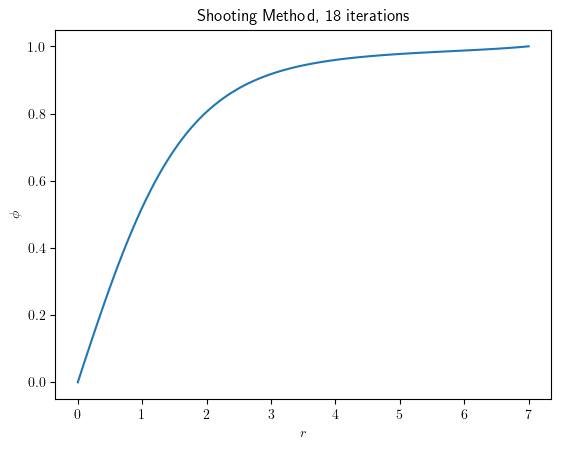

In [16]:
y, n_iterations = shooting_method([1.1, 1.3], r, 1)
plt.plot(r, y)
plt.xlabel(r'$r$')
plt.ylabel(r'$\phi$')
plt.title(r'Shooting Method, {} iterations'.format(n_iterations))
plt.show()

The boundary value problem can be expressed as
\begin{equation}
F(\phi) =
\begin{cases}
\frac{d^2\phi}{dr^2} + \frac{1}{r}\frac{d\phi}{dr} - \frac{n^2}{r^2}\phi + (1-\phi^2)\phi = 0 \\
\phi(0)=0 \\
\phi(\infty) - 1 = 0
\end{cases}
\end{equation}


Then the Fréchet derivative is
\begin{equation}
F^{\,\prime}z = 
\begin{cases}
\left[\frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr} - \frac{n^2}{r^2} + 1 - 3\phi^2\right]z = 0\\
z(0)=0 \\
z(\infty) = 0
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F^{\,\prime}z=-F$ is
\begin{align}
\left[\frac{d^2}{dr^2} + \frac{1}{r}\frac{d}{dr} - \frac{n^2}{r^2} + 1 - 3\phi^2\right]z &= -\left[\frac{d^2\phi}{dr^2} + \frac{1}{r}\frac{d\phi}{dr} - \frac{n^2}{r^2}\phi + (1-\phi^2)\phi\right] \\
z(0) &= -\left[\phi(0)\right]\\
z(\infty) &= - \left[\phi(\infty) - 1\right]
\end{align}

We now want to solve this system using finite differences. Let $h$ be the space step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N+1$ points and $N$ spacings between those points of width $h$.

In [17]:
a, b = [0.001, 7] # [start point, end point]
N = 100 # number of points
h = (b-a)/N # space width
r = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance

Substituting the centered differences into the Newton-Kantorovich equation
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} + \frac{1}{r}\frac{z_{j+1}-z_{j-1}}{2h}-\frac{n^2}{r^2}z_j + z_j - 3\phi_j^2z_j &= -\left[\frac{\phi_{j-1} - 2\phi_j + \phi_{j+1}}{h^2} + \frac{1}{r}\frac{\phi_{j+1}-\phi_{j-1}}{2h} - \frac{n^2}{r^2}\phi_j + (1-\phi_j^2)\phi_j \right] \\
z_1 &= -\phi_1 \\
z_{N+1} &= -\left[\phi_{N+1} - 1\right]
\end{align}

Factoring the left hand side in terms of $z$
\begin{align}
z_{j-1}\left(\frac{1}{h^2}-\frac{1}{r}\frac{1}{2h}\right) + z_j\left(-\frac{2}{h^2} - \frac{n^2}{r^2} + 1 -3\phi_j^2\right) + z_{j+1}\left(\frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\right) &= -\left[\frac{\phi_{j-1} - 2\phi_j + \phi_{j+1}}{h^2} + \frac{1}{r}\frac{\phi_{j+1}-\phi_{j-1}}{2h} - \frac{n^2}{r^2}\phi_j + (1-\phi_j^2)\phi_j \right] \\
z_1 &= -\phi_1 \\
z_{N+1} &= -\left[\phi_{N+1} - 1\right]
\end{align}

We can now express $F'$ as a Jacobian matrix
\begin{equation}
F'=
\begin{pmatrix}
1 & 0 & & & \cdots & 0 \\
\frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2} - \frac{n^2}{r^2} + 1 -3\phi_2^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & & \cdots & 0\\
0& \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2} - \frac{n^2}{r^2} + 1 -3\phi_3^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & \cdots & 0\\
\vdots & & & & & \vdots \\
0 & \cdots & 0 & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2} - \frac{n^2}{r^2} + 1 -3\phi_N^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} \\
0 & 0 & \cdots & 0 & 0 & 1
\end{pmatrix}
\end{equation}

In [18]:
def jacobian_f(N, r, phi, h, n):
    jacobian = np.zeros((N+1, N+1)) # creates an N+1 by N+1 dimension array
    
    jacobian[(0, 0)] = 1
    jacobian[(0, 1)] = 0
    
    jacobian[(N, N)] = 1
    
    diag_1 = []
    diag_2 = []
    diag_3 = []

    for i in range(1, N):
        diag_1.append((1/(h**2))-(1/r[i])*(1/(2*h)))
        diag_2.append(-(2/(h**2))-((n**2)/(r[i]**2))+1-3*phi[i]**2)
        diag_3.append((1/(h**2))+(1/r[i])*(1/(2*h)))

    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

Similarly, we can express $-F$ as a vector to solve $F'z=-F$
\begin{equation*}
-\vec{F}=
\begin{pmatrix}
-\phi_1 \\
-\frac{\phi_{j-1} - 2\phi_j + \phi_{j+1}}{h^2} - \frac{1}{r}\frac{\phi_{j+1}-\phi_{j-1}}{2h} + \frac{n^2}{r^2}\phi_j - (1-\phi_j^2)\phi_j  \\
-\phi_{N+1} + 1
\end{pmatrix}
\end{equation*}

In [19]:
def vec_f(N, r, phi, h, n):
    A = np.zeros(N + 1)
    A[0] = -phi[0]
    A[N] = -phi[N]+1

    for i in range(1, N):
        A[i] = (-(phi[i-1] - 2*phi[i] + phi[i+1])/(h**2) - (1/r[i])*((phi[i+1]-phi[i-1])/(2*h)) + 
                ((n**2)/(r[i]**2))*phi[i] - (1-phi[i]**2)*phi[i])

    return A

We can now create a while loop to iteratively solve for $\vec{y}$ with corrections $\vec{z}$

In [20]:
def newton_kantorovich_method_f(N, r, phi, h, n, tol):
    n_iterations = 0
    A = vec_f(N, r, phi, h, n)

    while norm(A) > tol and n_iterations < 100:
        jacobian = jacobian_f(N, r, phi, h, n)
        z = solve(jacobian, A)
        phi = phi + z
        A = vec_f(N, r, phi, h, n)
        n_iterations = n_iterations + 1

    return y, n_iterations

We can now test this using the values obtained from the shooting method as the ansatz for $y$ 

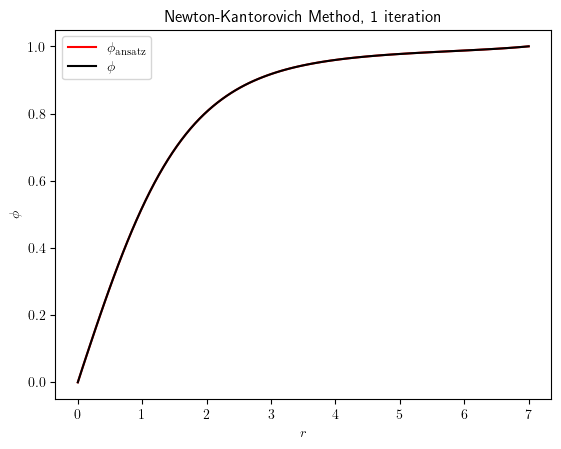

In [21]:
phi_ansatz = shooting_method([1.1, 1.3], r, 1)[0]
phi, n_iterations = newton_kantorovich_method_f(N, r, phi_ansatz, h, 1, tol)
plot_f(r, phi_ansatz, y, n_iterations, 'r', '\phi')

We can also test this using a different ansatz
\begin{equation}
\phi(r) = \frac{1}{1+r^2}
\end{equation}

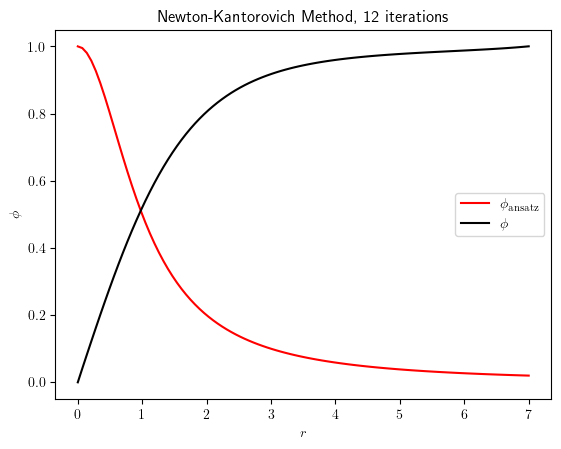

In [22]:
phi_ansatz = 1/(1+r**2)
phi, n_iterations = newton_kantorovich_method_f(N, r, phi_ansatz, h, 1, tol)
plot_f(r, phi_ansatz, phi, n_iterations, 'r', '\phi')